<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/projet_4_Analyse_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des ventes d’une librairie
Après avoir procédé au nettoyage et à la préparation des données dans la première partie du projet, nous allons désormais nous concentrer sur l’analyse des ventes de l’entreprise. Cette étape a pour objectif de dégager les principaux indicateurs de performance (CA, volume, panier moyen), d’identifier les profils clients les plus contributifs, ainsi que de mettre en évidence les tendances et disparités selon les catégories de produits, l’âge ou le sexe des acheteurs. L’analyse vise ainsi à fournir une vision claire et structurée de l’activité commerciale, étape préalable à la formulation de recommandations stratégiques.





>








## 1. Chargement et fusion des données

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as pylab
from matplotlib import cycler
import re


In [145]:
#autorisation d'acces au google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#importation des données depuis un ficher dans google drive
import os, glob

DATA_DIR = "/content/drive/MyDrive/Projet_P4/Data_p4_clean"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

# Charger tous les CSV dans un dictionnaire
import pandas as pd
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

Mounted at /content/drive
Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_P4/Data_p4_clean/transactions_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/customers_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/products_clean.csv


**Configuration Pandas**

In [146]:

# Afficher toutes les colonnes sans troncature
pd.set_option("display.max_columns", None)
# Limiter le nombre de lignes affichées
pd.set_option("display.max_rows", 100)
# Formater les floats pour plus de lisibilité
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [147]:
#appeler et renommer les dataframes
customers= dfs["customers_clean.csv"]
products = dfs["products_clean.csv"]
transactions = dfs["transactions_clean.csv"]

**Création de la table de fait df_tf**

##Création de la mega DataFrame (df_tf)

Sachant que:

* transactions = table de faits (chaque ligne = un achat)

* products = table de dimensions (prix, catégorie des produits)

* customers = table de dimensions (sexe, date de naissance des clients)

Nous allons créé une table de faits enrichie en joignant les 3 dataframes. On obtient alors une seule mega DataFrame (df_tf) qui contient :

* Grain : une ligne = une transaction.

* Mesures : prix, CA, volume.

* Dimensions : tout ce qui décrit la transaction (produit, catégorie, client, sexe, âge, date…).


In [148]:
df_transactions = transactions.copy()
df_products = products.copy()
df_customers = customers.copy()

In [149]:
df_transactions.loc[:, "id_prod"] = df_transactions["id_prod"].astype(str).str.strip()
df_products.loc[:, "id_prod"] = df_products["id_prod"].astype(str).str.strip()

df_transactions["date"] = pd.to_datetime(df_transactions["date"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
df_transactions['month'] = df_transactions['date'].dt.to_period('M')


In [150]:
print("client_id unique dans customers ?", df_customers["client_id"].is_unique)
print("nid_prod est unique ?", df_products["id_prod"].is_unique)



client_id unique dans customers ? True
nid_prod est unique ? True


In [151]:
print("Doublons exacts de lignes transactions :", df_transactions.duplicated().sum())
print("Doublons exacts de lignes customers :", df_customers.duplicated().sum())
print("Doublons exacts de lignes products :", df_products.duplicated().sum())

Doublons exacts de lignes transactions : 0
Doublons exacts de lignes customers : 0
Doublons exacts de lignes products : 0


In [152]:
invalid_clients = set(df_transactions["client_id"]) - set(df_customers["client_id"])
print("Clients dans transactions mais pas dans customers :", len(invalid_clients))

invalid_products = set(df_transactions["id_prod"]) - set(df_products["id_prod"])
print("Produits dans transactions mais pas dans products :", len(invalid_products))

Clients dans transactions mais pas dans customers : 0
Produits dans transactions mais pas dans products : 0


In [153]:
df_customers = df_customers[(df_customers.client_id != 'ct_0') & (df_customers.client_id != 'ct_1')]
df_products = df_products[(df_products.id_prod != '0_2245')]

In [154]:

df_transactions["date"] = pd.to_datetime(df_transactions["date"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
df_transactions['month'] = df_transactions['date'].dt.to_period('M')


In [155]:

df_tf = (
    df_transactions
      .merge(df_products,  on="id_prod",    how="left")
      .merge(df_customers, on="client_id",  how="left")
)
df_tf.head()

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,45
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02,65.75,2,f,2000,22
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,43
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,59
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,42


In [156]:
df_tf["date"]  = pd.to_datetime(df_tf["date"], errors="coerce")
df_tf["price"] = pd.to_numeric(df_tf["price"], errors="coerce")
df_tf["month"] = df_tf["date"].dt.to_period("M")
df_tf["categ"] = pd.to_numeric(df_tf["categ"], errors="coerce").astype("Int64")

# Analyse des données

L’analyse suivra une démarche progressive, répondant aux exigences fixées :

**Exploration descriptive des données**

Présentation des principales variables disponibles (quantitatives et qualitatives).

Calcul d’indicateurs de tendance centrale et de dispersion (moyenne, médiane, écart-type, minimum, maximum).

**Analyse de la distribution des ventes**

  - Étude de la concentration du chiffre d’affaires par client et par produit.

  - Construction d’une courbe de Lorenz et calcul de l’indice de Gini pour mesurer l’inégalité de répartition des ventes.

**Visualisation des données**

  - Réalisation de représentations graphiques variées :

  - Histogrammes (ex. distribution des prix, des âges).

  - Boîtes à moustaches (boxplots) pour détecter valeurs extrêmes et comparer des groupes.

  - Séries temporelles (évolution des ventes dans le temps).


##Exploration descriptive des données

###KPIs globaux

In [157]:


# ======================
# 1. KPIs globaux
# ======================
print("=== KPIs GLOBAUX ===")
print("Nombre total de transactions :", len(df_tf))
print("Nombre de clients uniques :", df_tf["client_id"].nunique())
print("Nombre de produits distincts vendus :", df_tf["id_prod"].nunique())
print("CA total :", df_tf["price"].sum())

=== KPIs GLOBAUX ===
Nombre total de transactions : 336713
Nombre de clients uniques : 8600
Nombre de produits distincts vendus : 3264
CA total : 5796577.7700000005


In [158]:
# Produits vendus (ceux qui apparaissent dans au moins une session)
produits_vendus = set(df_tf.loc[df_tf["session_id"].notna(), "id_prod"].unique())

# Tous les produits (dans la table)
tous_produits = set(df_tf["id_prod"].unique())

# Produits jamais vendus
produits_non_vendus = tous_produits - produits_vendus

print(f"Nombre de produits jamais vendus : {len(produits_non_vendus)}")
print(f"Produits non vendus : {list(produits_non_vendus)[:10]}")

Nombre de produits jamais vendus : 0
Produits non vendus : []


Avec 336 713 transactions réalisées par 8 600 clients uniques, l'entreprise a généré un chiffre d'affaires total de 5,8 millions d'euros en vendant 3 264 produits distincts."

## 2. Statistiques descriptives du chiffre d’affaires

In [159]:


print("===Statistiques de tendance centrale et dispersion ===")
stats = df_tf['price'].describe()
IQR = stats['75%'] - stats['25%']
print(stats)
print(f'IQR : {IQR:.2f}')




===Statistiques de tendance centrale et dispersion ===
count   336713.00
mean        17.22
std         17.86
min          0.62
25%          8.61
50%         13.90
75%         18.99
max        300.00
Name: price, dtype: float64
IQR : 10.38


* **Moyenne (17,22 €) et médiane (13,90 €)** sont proches mais pas identiques, ce qui confirme la présence d’une queue à droite (quelques valeurs élevées tirent la moyenne vers le haut).

* **L’IQR (10,38 €)** indique que la majorité des prix est concentrée dans une plage relativement restreinte (entre 8,61 € et 18,99 €).

* **La valeur maximale (300 €)** est plus de 17 fois supérieure à la médiane, ce qui traduit la présence de valeurs extrêmes peu fréquentes mais significatives.

#### Distribution des montants dee vente

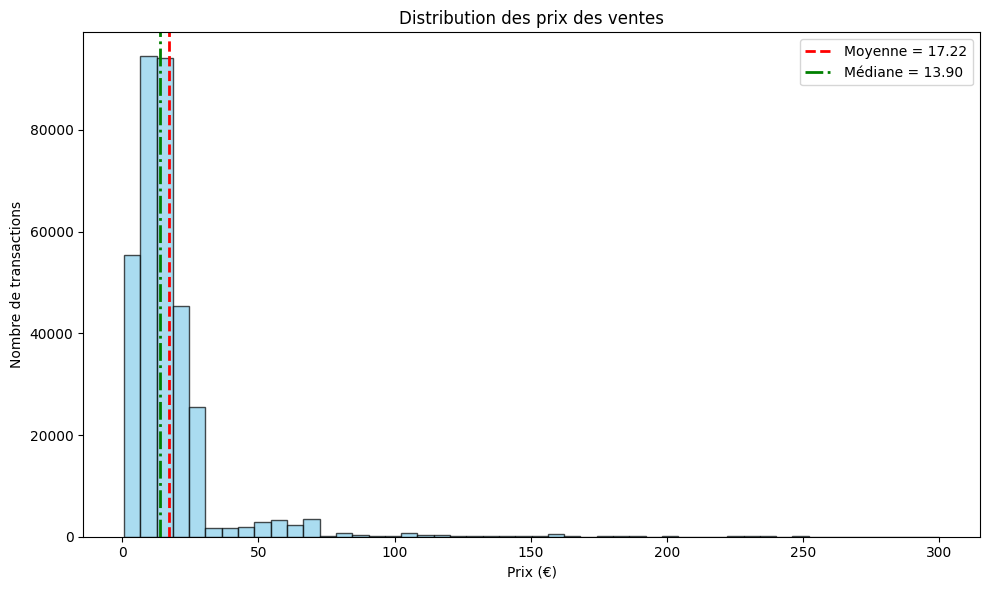

In [160]:

df = df_tf
plt.figure(figsize=(10,6))
plt.hist(df["price"], bins=50, color="skyblue", edgecolor="black", alpha=0.7)


plt.axvline(df["price"].mean(), color="red", linestyle="--", linewidth=2, label=f"Moyenne = {df['price'].mean():.2f}")
plt.axvline(df["price"].median(), color="green", linestyle="-.", linewidth=2, label=f"Médiane = {df['price'].median():.2f}")

plt.title("Distribution des prix des ventes")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de transactions")
plt.legend()
plt.tight_layout()
plt.show()

**Interprétation :**

**Deux comportements** d’achat se distinguent :

* **Clientèle majoritaire** : achats à petits montants mais très fréquents — ils représentent le cœur de la distribution.

* **Clientèle minoritaire** : achats plus rares mais plus onéreux, contribuant de manière disproportionnée au chiffre d’affaires global.


Le marché présente une **segmentation** naturelle entre acheteurs **“quotidiens”** et acheteurs **“premium”**.

Une part importante du CA est probablement concentrée sur une minorité de transactions, phénomène typique d’une distribution de type **loi de Pareto** (80-20).

Pour confirmer ce phénomène, nous allons compléter cette analyse par :

* une courbe de Lorenz,

* un indice de Gini,

* une analyse du CA par tranche de prix.

###Analyse temporelle ( par mois)

In [161]:
periode = pd.period_range(
    start=df_tf["month"].min(),
    end=df_tf["month"].max(),
    freq="M"
)

In [162]:

tx_mensuel = (
    df_tf.groupby("month", observed=True)
         .size()
    .reindex(periode, fill_value=0)
)

df_tx_mensuel = tx_mensuel.copy()
df_tx_mensuel.index = df_tx_mensuel.index.to_timestamp()


In [163]:

sessions_mensuel = (
    df_tf.groupby("month", observed=True)["session_id"]
         .nunique()
    .reindex(periode, fill_value=0)
)
df_sessions_mensuel = sessions_mensuel.copy()
df_sessions_mensuel.index = df_sessions_mensuel.index.to_timestamp()

In [164]:

ca_mensuel = (
    df_tf.groupby("month", observed=True)["price"]
         .sum()
    .sort_index()
)

df_ca_mensuel = ca_mensuel.copy()
df_ca_mensuel.index = df_ca_mensuel.index.to_timestamp()

print("===CA Mensuel===")
print(df_ca_mensuel)



===CA Mensuel===
month
2021-03-01   479312.03
2021-04-01   472980.72
2021-05-01   489367.95
2021-06-01   481257.94
2021-07-01   480898.66
2021-08-01   479305.19
2021-09-01   502771.28
2021-10-01   319159.96
2021-11-01   512890.17
2021-12-01   522937.68
2022-01-01   522955.31
2022-02-01   532740.88
Freq: MS, Name: price, dtype: float64


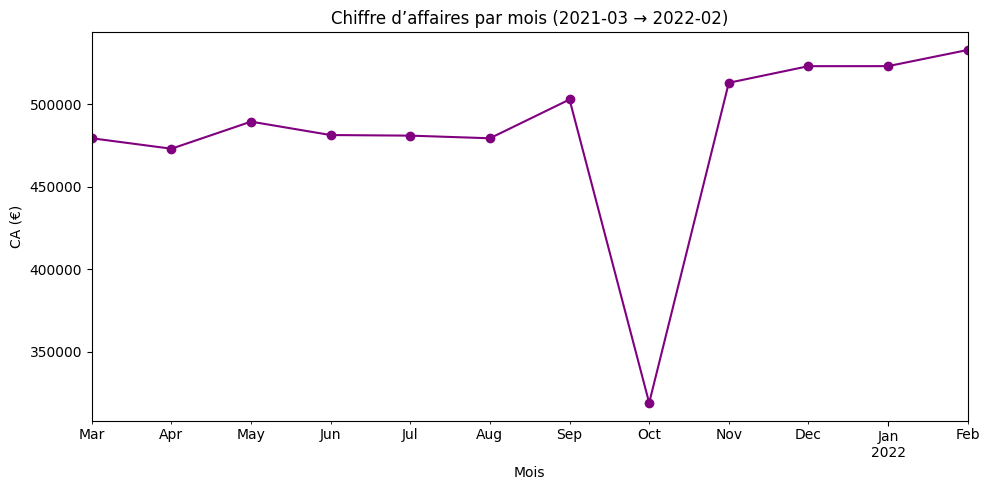

In [165]:
plt.figure(figsize=(10,5))
df_ca_mensuel.plot(marker="o", color = "purple", title="Chiffre d’affaires par mois (2021-03 → 2022-02)")
plt.ylabel("CA (€)")
plt.xlabel("Mois")
plt.tight_layout()
plt.show()





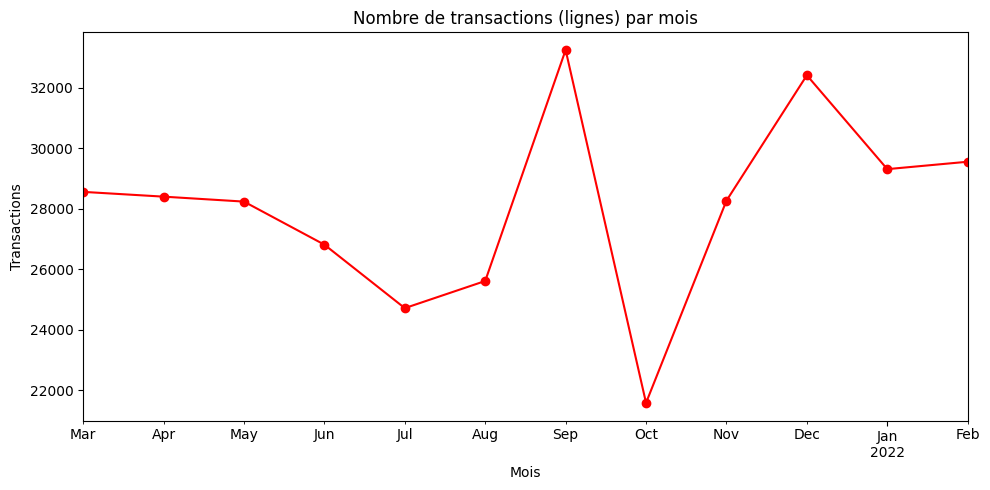

In [166]:
plt.figure(figsize=(10,5))
df_tx_mensuel.plot(marker="o",color = "red", title="Nombre de transactions (lignes) par mois")
plt.ylabel("Transactions")
plt.xlabel("Mois")
plt.tight_layout()
plt.show()



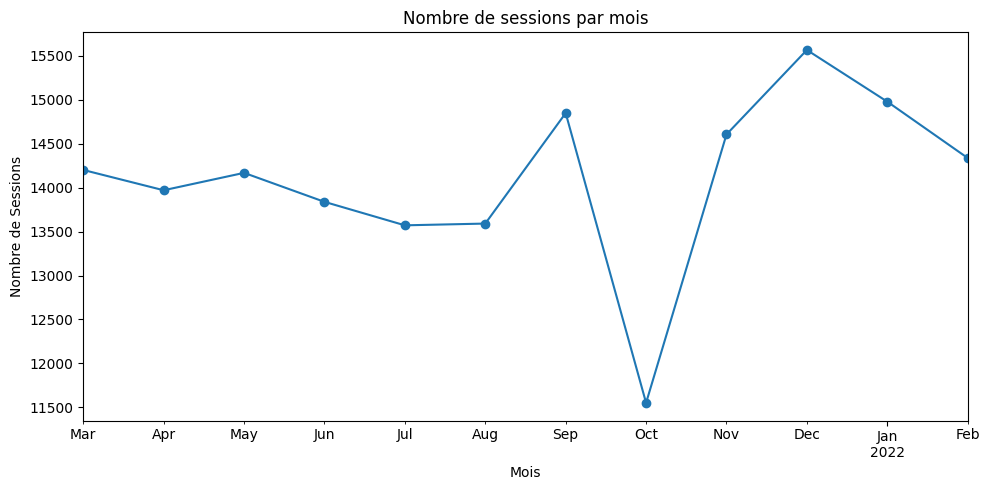

In [167]:
plt.figure(figsize=(10,5))
df_sessions_mensuel.plot(marker="o", title="Nombre de sessions par mois")
plt.ylabel("Nombre de Sessions")
plt.xlabel("Mois")
plt.tight_layout()
plt.show()

on remarque une incohérence au mois d'octobre, on va donc essayer de comprendre ce qui ce passe durant ce mois: création d'une df ciblée

####*analyse des transaction du mois d'octobre*

In [168]:
oct21= df_tf[df_tf["month"] == "2021-10"]

print("Transactions Oct 2021 :")
print(oct21["price"].describe())

Transactions Oct 2021 :
count   21577.00
mean       14.79
std        17.54
min         0.62
25%         6.99
50%        11.03
75%        15.99
max       247.22
Name: price, dtype: float64


In [169]:

prix_moyen_mensuel = (
    df_tf.groupby("month", observed=True)["price"].mean().sort_index()
)
print("Prix moyen mensuel:")
print(prix_moyen_mensuel)



Prix moyen mensuel:
month
2021-03   16.78
2021-04   16.65
2021-05   17.33
2021-06   17.95
2021-07   19.46
2021-08   18.72
2021-09   15.12
2021-10   14.79
2021-11   18.14
2021-12   16.13
2022-01   17.84
2022-02   18.02
Freq: M, Name: price, dtype: float64


In [170]:
print("CA moyen Oct 2021 :", oct21["price"].mean())
oct_mask = (df_tf["month"] == pd.Period("2021-10"))
print("CA moyen autres mois :", df_tf.loc[~oct_mask, "price"].mean())

CA moyen Oct 2021 : 14.791674468183714
CA moyen autres mois : 17.38112373705321


In [171]:
# on fait une fenêtre de comparaison Sep–Nov
cmp = (
    df_tf[df_tf["month"].isin(pd.period_range("2021-09","2021-11", freq="M"))]
    .groupby("month", observed=True)
    .agg(
        tx=("price","size"),                     # lignes/transactions
        ca=("price","sum"),
        sessions=("session_id","nunique"),
        panier_moyen=("price","mean")
    )
    .sort_index()
)
print(cmp)


            tx        ca  sessions  panier_moyen
month                                           
2021-09  33254 502771.28     14848         15.12
2021-10  21577 319159.96     11551         14.79
2021-11  28267 512890.17     14605         18.14


on analyse les transactions du mois d'octobre en fonction des catégories

In [172]:
# indx Octobre 2021
idx = pd.date_range("2021-10-01", "2021-10-31", freq="D")
df_oct = df_tf[df_tf["month"] == pd.Period("2021-10")].copy()
df_oct["day"] = df_oct["date"].dt.floor("D")

#  Pivot transactions/jour × catégorie + controle
pivot_oct = (
    df_oct.pivot_table(index="day",
                       columns="categ",
                       values="id_prod",
                       aggfunc="count",
                       fill_value=0)
    .reindex(idx, fill_value=0)
    .sort_index()
)

# Totaux et parts
pivot_oct["nb_tx_total"] = pivot_oct.sum(axis=1)

print(pivot_oct.head(31))

categ         0    1   2  nb_tx_total
2021-10-01  662  344  37         1043
2021-10-02  660    0  27          687
2021-10-03  647    0  30          677
2021-10-04  600    0  37          637
2021-10-05  594    0  38          632
2021-10-06  701    0  25          726
2021-10-07  597    0  26          623
2021-10-08  669    0  44          713
2021-10-09  640    0  35          675
2021-10-10  599    0  28          627
2021-10-11  642    0  42          684
2021-10-12  632    0  29          661
2021-10-13  633    0  36          669
2021-10-14  605    0  39          644
2021-10-15  632    0  37          669
2021-10-16  661    0  45          706
2021-10-17  625    0  44          669
2021-10-18  608    0  37          645
2021-10-19  565    0  37          602
2021-10-20  554    0  42          596
2021-10-21  610    0  43          653
2021-10-22  571    0  34          605
2021-10-23  555    0  47          602
2021-10-24  584    0  44          628
2021-10-25  545    0  32          577
2021-10-26  

In [173]:
absence_par_categ = (pivot_oct.drop(columns="nb_tx_total", errors="ignore") == 0).sum()
print("Jours d’absence par catégorie en octobre :", absence_par_categ.sort_values(ascending=False))


Jours d’absence par catégorie en octobre : categ
1    26
0     0
2     0
dtype: int64


In [174]:
parts_oct = pivot_oct.div(pivot_oct["nb_tx_total"].replace({0:1}), axis=0)  # parts par jour (évite /0)
parts_oct = parts_oct.drop(columns=["nb_tx_total"], errors="ignore")


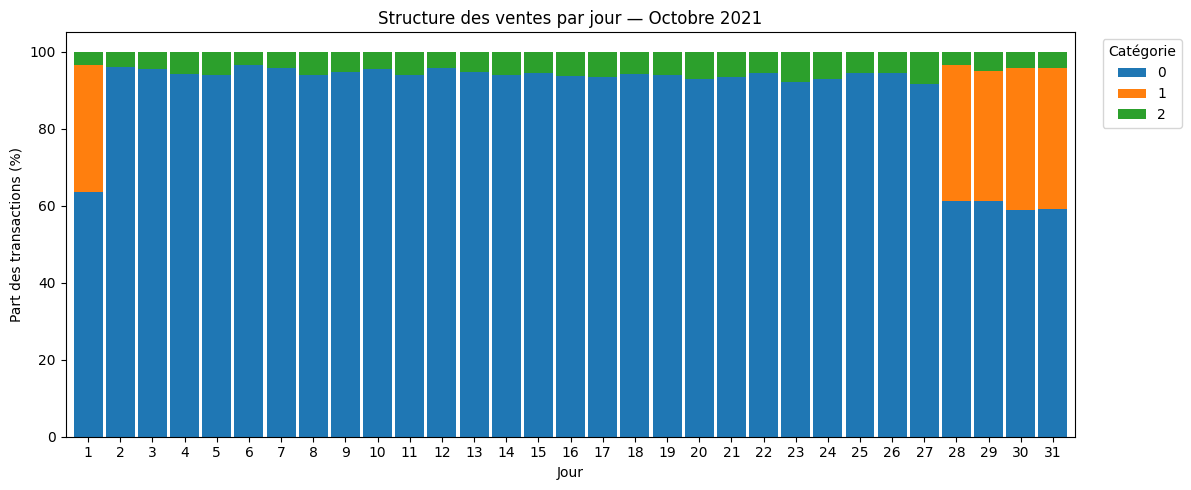

In [175]:
ax = (100*parts_oct).plot(kind="bar", stacked=True, figsize=(12,5), width=0.9)
plt.title("Structure des ventes par jour — Octobre 2021")
plt.ylabel("Part des transactions (%)")
plt.xlabel("Jour")
plt.xticks(ticks=range(len(parts_oct.index)), labels=[d.day for d in parts_oct.index], rotation=0)
plt.legend(title="Catégorie", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout();
plt.show()


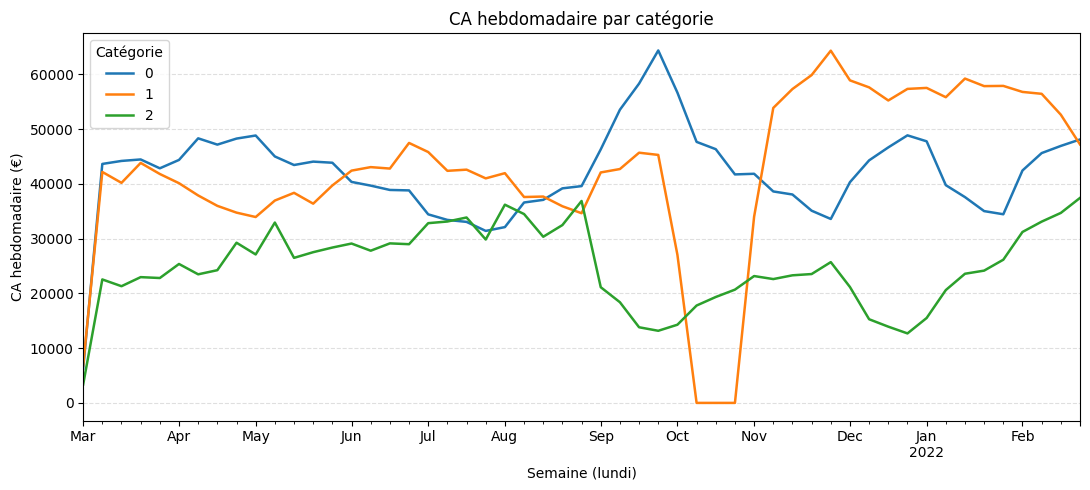

In [176]:
df = df_tf.copy()

# Index temporel + agrégation hebdo (lundi)
df = df.set_index("date")
weekly = (
    df.groupby("categ")["price"]
      .resample("W-MON")
      .sum()
      .unstack(0)
      .sort_index()
)

ax = weekly.plot(figsize=(11,5), linewidth=1.8)
ax.set_title("CA hebdomadaire par catégorie")
ax.set_xlabel("Semaine (lundi)")
ax.set_ylabel("CA hebdomadaire (€)")
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Catégorie", loc="upper left")
plt.tight_layout();
plt.show()

L’analyse montre une perte de données sur la catégorie 1 entre le 2 et le 28 octobre 2021, alors que cette catégorie est présente aux fréquences habituelles sur les autres périodes.

Deux options étaient envisageables :

Corriger octobre en imputant les données manquantes par interpolation (moyenne entre septembre et novembre).

Exclure octobre des calculs afin de ne conserver que des valeurs réellement observées.

Nous avons choisi la seconde option : supprimer le mois d’octobre 2021 des analyses. Cela permet de travailler sur une base de 11 mois complets reflétant un chiffre d’affaires réel, sans introduire d’estimation artificielle.

Octobre 2021 présente un chiffre d’affaires exceptionnellement bas: 319 k€ vs ~ 490 k€ en moyenne mensuelle. La chute est de −35 % par rapport à la moyenne mensuelle. Cela correspond à un manque d’environ 171 k€, soit ~3 % du CA total sur la période.

L’analyse détaillée montre que le prix moyen reste stable: ~15 €, mais que le nombre de transactions enregistrées 21 577 est nettement inférieur à celui des mois voisins: ~30–35k.

Cela reste faible à l’échelle globale, mais significatif dans une analyse mensuelle, car le mois d’octobre apparaît artificiellement comme une contre-performance.

Cette baisse est donc sans doute liée à un volume de transactions incomplet (probablement dû à un à un volume de transactions incomplet (probablement dû à un problème de collecte ou d’intégration des données)
à un incident opérationnel ( indisponibilité du site, bug technique ayant limité les ventes etc...)
et non à une variation commerciale réelle.




## Analyse par produit

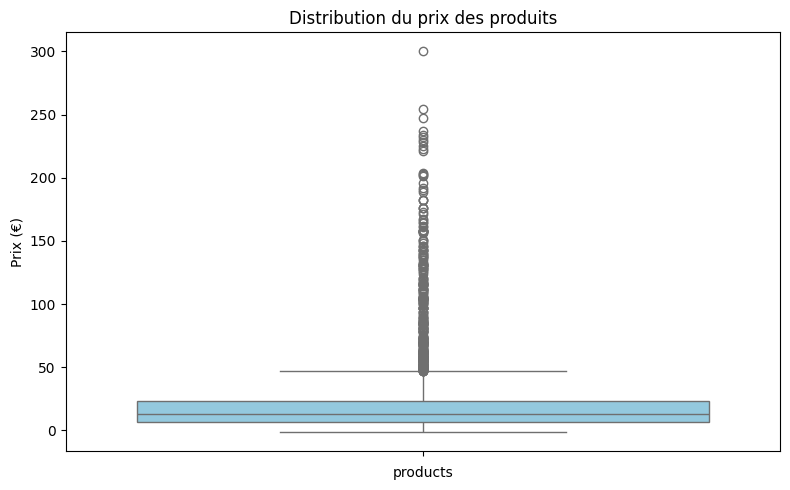

In [177]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_products, y="price", color="skyblue", showfliers=True)
plt.title("Distribution du prix des produits")
plt.ylabel("Prix (€)")
plt.xlabel("products")
plt.tight_layout()
plt.show()


####Top 10 des produits

In [178]:
top_products = (
    df.groupby("id_prod", observed=True)["price"]
      .sum()
      .nlargest(10)
      .sort_values(ascending=True)      # pour barh
)


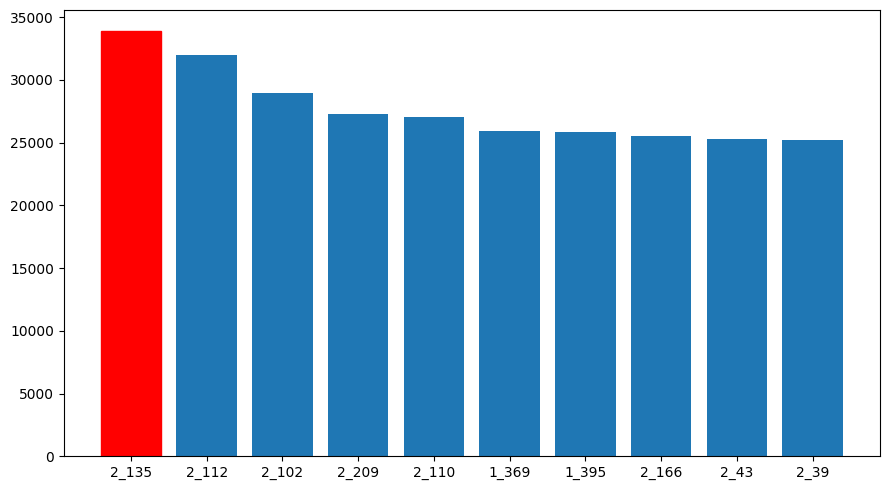

In [179]:

ca_total = df_tf["price"].sum()
top_df = top_products.to_frame(name="price")
top_df["pct_total"] = top_df["price"] / ca_total

s = top_products.nlargest(10)                 # s est décroissant
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(s.index.astype(str), s.values)
bars[0].set_color("red")
plt.tight_layout(); plt.show()



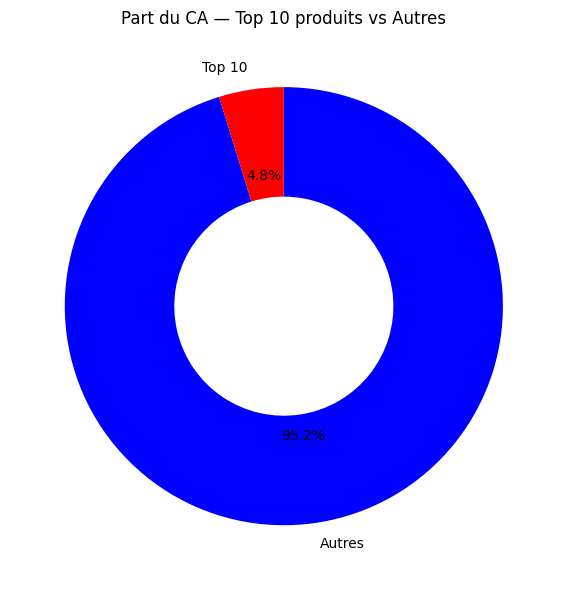

In [180]:
top10_sum   = top_products.sum()
others_sum  = max(0, ca_total - top10_sum)

# Donut Top10 vs Autres
labels = ["Autres", "Top 10"]
values = [others_sum, top10_sum]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    values,
    labels=labels,
    colors=colors,
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    counterclock=False,
    wedgeprops={"width": 0.5}   # donut
)
ax.set_title("Part du CA — Top 10 produits vs Autres")
plt.tight_layout()

Les 10 produits les plus vendus génèrent chacun entre 25 k€ et 34 k€ sur la période, soit 0,44 % à 0,58 % du CA total.

 Cela montre que le chiffre d’affaires n’est pas concentré sur quelques références, mais réparti sur un très grand nombre de produits. Même le produit leader (2_135) ne représente que 0,6 % du CA global.


#### Distribution du nb de produit acheté par clients (hors grossistes)

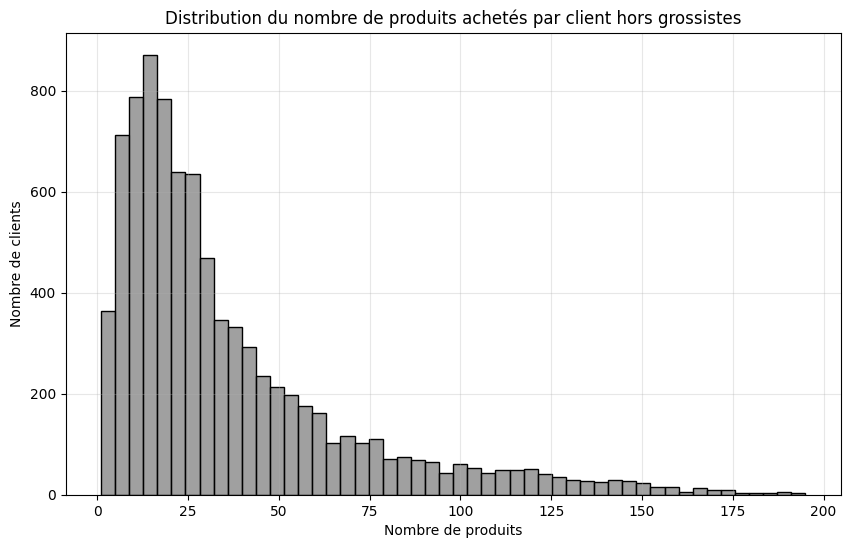

In [181]:
produits_par_client = df.groupby('client_id')["id_prod"].count()
plt.figure(figsize=(10,6))
sns.histplot(produits_par_client[produits_par_client < 500], bins=50, color="grey")
plt.title("Distribution du nombre de produits achetés par client hors grossistes")
plt.xlabel("Nombre de produits")
plt.ylabel("Nombre de clients")
plt.grid(True, alpha=0.3)
plt.show()

* Pic autour de 15 à 25 produits

* La majorité des clients achètent entre 10 et 30 produits, cela correspond à un comportement d’achat « standard » ou occasionnel.

* Forte asymétrie à droite (queue longue)

* Le nombre de clients diminue fortement au-delà de 30 produits.

* Il existe quelques clients très actifs qui achètent jusqu’à 200 produits, mais ils sont rare ( les grossistes)

CCL a majorité des clients achètent peu de produits, tandis qu’une minorité achète énormément. Ce type de distribution, très asymétrique, est typique d’une base client où une petite part génère une grande valeur.

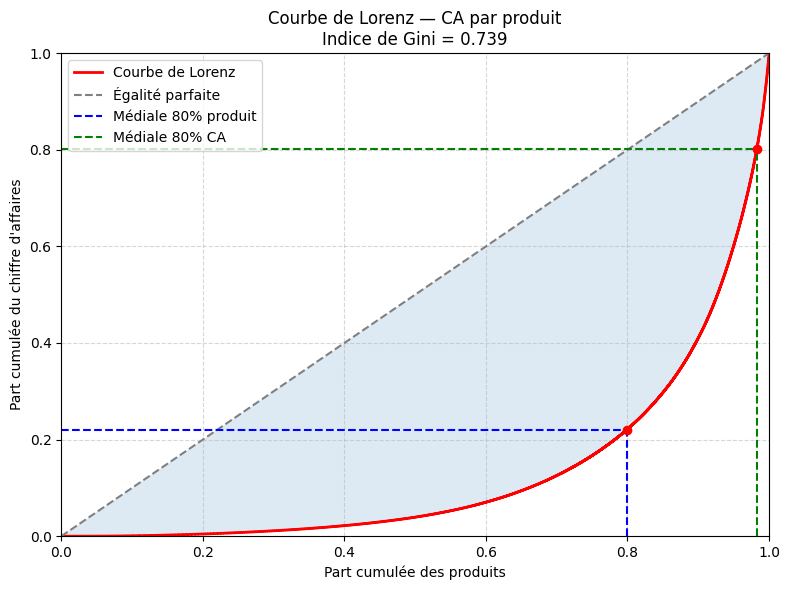

In [182]:
s = (df_tf[["id_prod","price"]].dropna()
     .groupby("id_prod")["price"].sum()
     .sort_values())


n = len(s)
x = np.r_[0, np.arange(1, n+1)/n]            # part cumulée des produits
y = np.r_[0, s.cumsum()/s.sum()]             # part cumulée du CA

# Gini
gini = 1 - 2*np.trapezoid(y, x)


plt.figure(figsize=(8,6))
plt.plot(x, y, color = "red", lw=2, drawstyle='steps-post', label="Courbe de Lorenz")
plt.plot([0,1], [0,1], ls='--', color='gray', label="Égalité parfaite")
plt.fill_between(x, y, x, alpha=0.15)
plt.legend(loc="upper left")

# Médial
idx = np.searchsorted(y, 0.22)
x_medial = x[idx]
y_medial = y[idx]
plt.vlines(x_medial, ymin=0, ymax=y_medial, color='blue', linestyle='--', label='Médiale 80% produit')
plt.hlines(y_medial, xmin=0, xmax=x_medial, color='blue', linestyle='--')
plt.scatter([x_medial], [y_medial], color='red', zorder=5)

idx2 = np.searchsorted(y, 0.8)
x_medial = x[idx2]
y_medial = y[idx2]
plt.vlines(x_medial, ymin=0, ymax=y_medial, color='green', linestyle='--', label='Médiale 80% CA')
plt.hlines(y_medial, xmin=0, xmax=x_medial, color='green', linestyle='--')
plt.scatter([x_medial], [y_medial], color='red', zorder=5)

# quadrillage
ax = plt.gca()
ax.set(xlim=(0,1), ylim=(0,1),
       xlabel="Part cumulée des produits",
       ylabel="Part cumulée du chiffre d'affaires",
       title=f"Courbe de Lorenz — CA par produit\nIndice de Gini = {gini:.3f}")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.tight_layout();
plt.show()

* Indice de Gini = 0,739
* 80% des produits génèrent environs 22% du CA
* ≈ 98 % des produits nécessaires pour 80 % du CA.

### Analyse par catégorie.

#### Nombre de produits par catégorie.

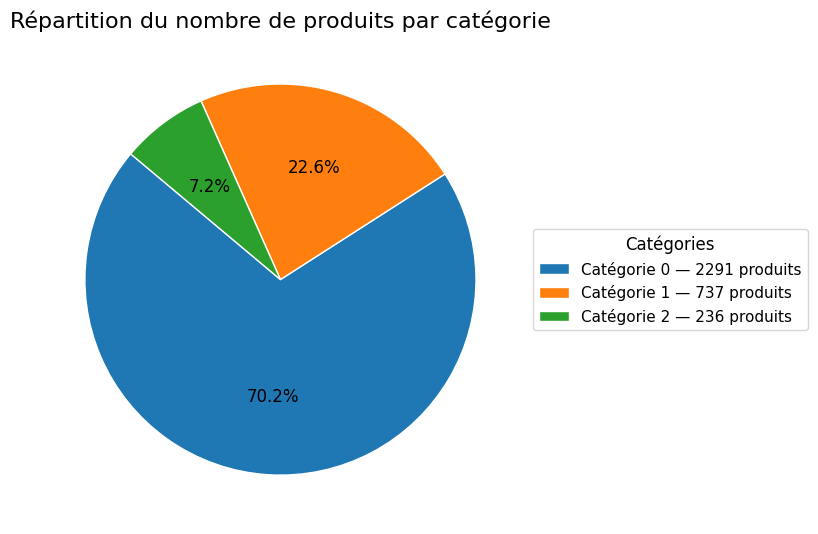

In [184]:
dfc = df_tf.copy()
dfc["categ"] = pd.to_numeric(dfc["categ"], errors="coerce").astype("Int64")
dfc = dfc.dropna(subset=["categ"])


nb_produits = dfc.groupby("categ")["id_prod"].nunique().sort_values(ascending=False)


couleurs = plt.cm.tab10.colors[:len(nb_produits)]


plt.figure(figsize=(8, 8))
wedges1, texts1, autotexts1 = plt.pie(
    nb_produits,
    autopct='%1.1f%%',
    startangle=140,
    colors=couleurs,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 12}
)

plt.legend(
    wedges1,
    [f"Catégorie {cat} — {val} produits" for cat, val in zip(nb_produits.index, nb_produits)],
    title="Catégories",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11,
    title_fontsize=12
)
plt.title('Répartition du nombre de produits par catégorie', fontsize=16)
plt.tight_layout()
plt.show()

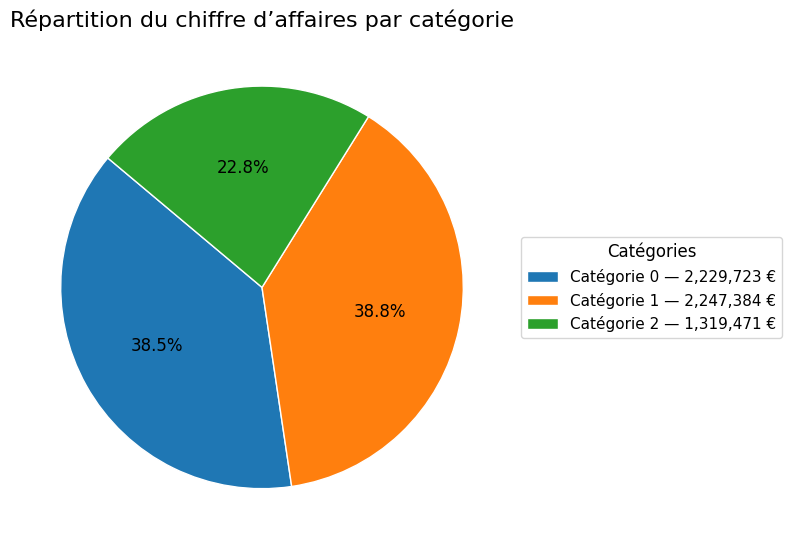

In [186]:

dfc = df_tf.copy()
ca_par_categ = dfc.groupby("categ")["price"].sum().reindex(nb_produits.index)

plt.figure(figsize=(8, 8))
wedges2, texts2, autotexts2 = plt.pie(
    ca_par_categ,
    autopct='%1.1f%%',
    startangle=140,
    colors=couleurs,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 12}
)

plt.legend(
    wedges2,
    [f"Catégorie {cat} — {val:,.0f} €" for cat, val in zip(ca_par_categ.index, ca_par_categ)],
    title="Catégories",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11,
    title_fontsize=12
)
plt.title('Répartition du chiffre d’affaires par catégorie', fontsize=16)
plt.tight_layout()
plt.show()

nb produit croissant par catégorie: cat0> Cat1> Cat2

#### Prix des articles les plus vendus par catégories

In [187]:
vc = df_tf["price"].value_counts()
print("Global:", vc.idxmax(), vc.max())
for c, s in df_tf.groupby("categ")["price"]:
    vc = s.value_counts()
    print(f"Categ {c}:", (vc.idxmax() if not vc.empty else np.nan), (vc.max() if not vc.empty else 0))


Global: 15.99 10563
Categ 0: 4.99 9306
Categ 1: 15.99 4865
Categ 2: 68.99 1085


In [188]:
 #Prix modes
modes = {
    "ALL": 15.99,
    0: 4.99,
    1: 15.99,
    2: 68.99,
}

df = df_tf.copy()
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["categ"] = pd.to_numeric(df["categ"], errors="coerce").astype("Int64")
df = df.dropna(subset=["price"])

def synth(scope, price_mode, cat=None):
    sub = df if cat is None else df[df["categ"] == cat]
    n = len(sub)
    n_mode = (sub["price"] == price_mode).sum()
    ca = sub["price"].sum()
    ca_mode = sub.loc[sub["price"] == price_mode, "price"].sum()
    return {
        "scope": scope,
        "prix_mode": price_mode,
        "freq": n_mode,
        "freq_%": 100 * n_mode / n if n else 0.0,
        "CA_part_%": 100 * ca_mode / ca if ca else 0.0,
    }

rows = [
    synth("Global", modes["ALL"], None),
    synth("Cat 0", modes[0], 0),
    synth("Cat 1", modes[1], 1),
    synth("Cat 2", modes[2], 2),
]
import pandas as pd
tbl = pd.DataFrame(rows)
print(tbl.round({"freq_%":2, "CA_part_%":2}))


    scope  prix_mode   freq  freq_%  CA_part_%
0  Global      15.99  10563    3.14       2.91
1   Cat 0       4.99   9306    4.44       2.08
2   Cat 1      15.99   4865    4.43       3.46
3   Cat 2      68.99   1085    6.18       5.67


On constate des produits paliers(leaders) pour chaque catégorie croissant de la cat 0 à 2

In [189]:
for p in [15.99, 4.99, 68.99]:
    top_ids = (df.loc[df["price"] == p]
                 .groupby("id_prod")["price"].size()
                 .sort_values(ascending=False).head(5))
    print(f"Top produits au prix {p} :")
    print(top_ids)


Top produits au prix 15.99 :
id_prod
1_407     933
1_381     842
1_483     690
1_459     687
0_1473    571
Name: price, dtype: int64
Top produits au prix 4.99 :
id_prod
0_1409    615
0_1405    576
0_1447    529
0_1449    497
0_1467    490
Name: price, dtype: int64
Top produits au prix 68.99 :
id_prod
2_135    491
2_163    265
2_41     192
2_127    137
Name: price, dtype: int64


pas de dépendence, les produits les plus vendus par catégories  ne representent qu'environs % du CA Global

#### Prix moyen des articles par catégorie.

#### Distribution des prix par catégorie

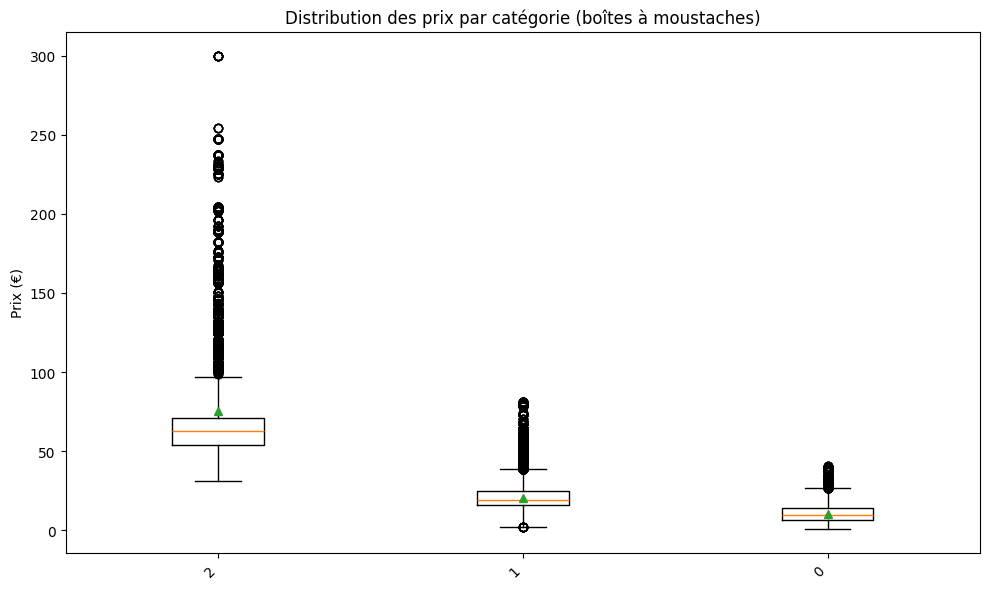

In [190]:

# Préparer les données : une liste de séries de prix par catégorie
order = (
    df.groupby("categ")["price"]
         .median()
         .sort_values(ascending=False)
         .index.tolist()
)
data = [df.loc[df["categ"] == c, "price"].dropna().values for c in order]

plt.figure(figsize=(10,6))
bp = plt.boxplot(
    data,
    vert=True,
    patch_artist=False,   # pas de couleur imposée
    showfliers=True,      # affiche les outliers
    showmeans=True,       # ligne de moyenne
    whis=1.5
)
plt.xticks(range(1, len(order)+1), order, rotation=45, ha="right")
plt.yscale("linear")      # tu peux passer en 'log' si très asymétrique
plt.title("Distribution des prix par catégorie (boîtes à moustaches)")
plt.ylabel("Prix (€)")
plt.tight_layout()
plt.show()



*  La catégorie 0 regroupe des produits d’entrée de gamme, peu chers ethomogènes.


*   La catégorie 1 se situe dans une gamme intermédiaire, avec des prix plus variés.



*  La catégorie 2 concentre les produits premium, caractérisés par des prix nettement supérieurs et une forte variabilité.


**Cela explique les différences observées dans la contribution au CA par catégorie car la catégorie 2 génère un quart du CA malgré seulement 5 % des volumes.**

Prix du panier moyen par catégorie

In [191]:

panier_session = df.groupby("session_id")["price"].sum().rename("panier_session")

ca_sess_cat = (
    df.groupby(["session_id","categ"])["price"].sum().rename("CA_sess_cat").reset_index()
)

panier_moy_cat = (
    ca_sess_cat.groupby("categ")["CA_sess_cat"].mean()
               .rename("panier_moyen_categ")
               .reset_index()
)

panier_moy_cat

,categ,panier_moyen_categ
0,0,19.74
1,1,26.02
2,2,89.62


#### Densité des prix par catégorie

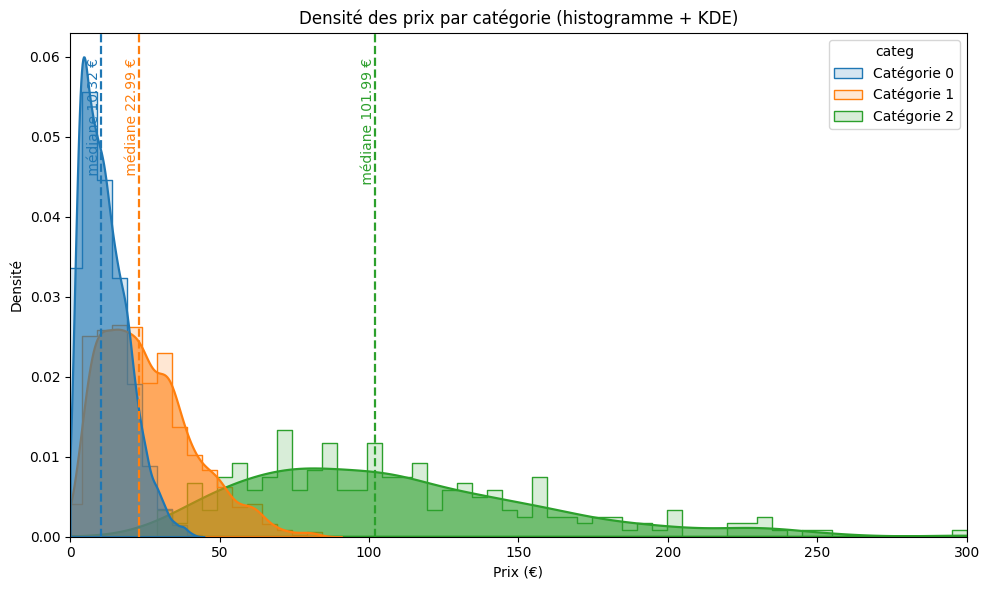

In [192]:
dfp = df_products.copy()
levels = ["Catégorie 0", "Catégorie 1", "Catégorie 2"]
cat_map = {0: levels[0], 1: levels[1], 2: levels[2]}
dfp["categ"] = pd.Categorical(dfp["categ"].map(cat_map), categories=levels, ordered=True)

palette = dict(zip(levels, sns.color_palette(n_colors=len(levels))))

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Histogrammes
sns.histplot(
    data=dfp, x="price", hue="categ", hue_order=levels,
    bins=60, element="step", stat="density", common_norm=False,
    alpha=0.18, palette=palette, ax=ax, legend=True
)

# KDE
sns.kdeplot(
    data=dfp, x="price", hue="categ", hue_order=levels,
    fill=True, common_norm=False, bw_adjust=0.8, clip=(0, None),
    linewidth=1.6, alpha=0.6, palette=palette, ax=ax, legend=False
)

for cat, g in dfp.groupby("categ", observed=True):
    med = g["price"].median()
    ax.axvline(med, linestyle="--", linewidth=1.6, color=palette[cat], zorder=6, label="_nolegend_")
    ax.text(med, ax.get_ylim()[1]*0.95, f" médiane {med:.2f} €",
            rotation=90, va="top", ha="right", color=palette[cat], zorder=7)

ax.set_xlim(0, 300)
ax.set_title("Densité des prix par catégorie (histogramme + KDE)")
ax.set_xlabel("Prix (€)")
ax.set_ylabel("Densité")


leg = ax.get_legend()


plt.tight_layout()
plt.show()

L’analyse par catégorie met en évidence trois profils distincts :

* **Catégorie 0 – Produits “courants”**
Produits à faible prix unitaire et fort volume : ils représentent 62 % des ventes mais seulement 38 % du chiffre d’affaires.
Les boxplots montrent une distribution de prix resserrée autour de la médiane (~10 €), avec peu de dispersion.
 **Ces articles constituent le socle du volume, mais contribuent seulement a enivorns 40% du CA.**

* **Catégorie 1 – Produits Millieu de gamme** : “équilibrés”
Représentent 33 % des ventes pour 39 % du CA.
Leurs prix sont modérés (médiane autour de 15 €) et plus homogènes, traduisant un positionnement milieu de gamme.
**Cette catégorie agit comme un stabilisateur : elle combine volume régulier et marge moyenne.**

* **Catégorie 2 – Produits haut de gamme** à forte valeur
Faible volume (~5 %) mais ~23 % du CA. Médiane ~102 €, forte dispersion avec queue haute (>200–300 €).
**Ces produits sont clairement haut de gamme, participe a pres d'1/4 du CA globale malgré leur faible fréquence d’achat.**

## Analyse CA par sexe

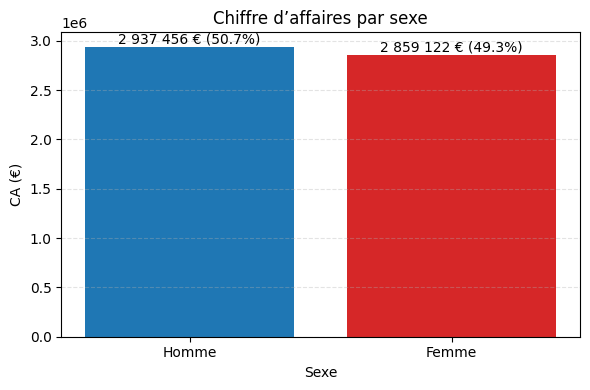

In [193]:
df_ = df.copy()
df_["sex"] = df_["sex"].astype("string").str.strip().str.upper()
df_["sex_lbl"] = df_["sex"].map({"F": "Femme", "M": "Homme"}).fillna("Inconnu")

# Agrégation (CA par sexe)
ca_by_sex = df_.groupby("sex_lbl")["price"].sum().sort_values(ascending=False)

# Couleurs (F, M, Inconnu)
palette = {"Femme": "#d62728", "Homme": "#1f77b4", "Inconnu": "#9e9e9e"}
colors = [palette.get(lbl, "#9e9e9e") for lbl in ca_by_sex.index]

# Barplot
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(ca_by_sex.index, ca_by_sex.values, color=colors)
ax.set_title("Chiffre d’affaires par sexe")
ax.set_xlabel("Sexe"); ax.set_ylabel("CA (€)")
ax.grid(True, axis="y", linestyle="--", alpha=0.35)


total = ca_by_sex.sum()
for r, v in zip(bars, ca_by_sex.values):
    ax.text(r.get_x()+r.get_width()/2, r.get_height(),
            f"{v:,.0f} € ({v/total:.1%})".replace(",", " "),
            ha="center", va="bottom")

plt.tight_layout(); plt.show()

CA Equilibré entre les Hommes et les Femmes



L’analyse par âge montre que la clientèle est surtout concentrée entre 35 et 50 ans en volume.

En termes de valeur :

Le CA moyen par client est le plus élevé chez les **30–55 ans**, confirmant qu’il s’agit de la cible **principale**.

Les clients plus jeunes (<30 ans) et plus âgés (>70 ans) dépensent significativement moins, ce qui réduit leur poids économique malgré leur présence.

Cela suggère que les actions marketing ou de **fidélisation** devraient cibler prioritairement les **30–55 ans**, qui combinent à la fois volume et rentabilité. Mais aussi d'établir une nouvelle stratégie pour **attirer fidéliser** les **jeunes adultes et les seniors.**

## 3. Analyse de concentration : Lorenz & Gini CA/client

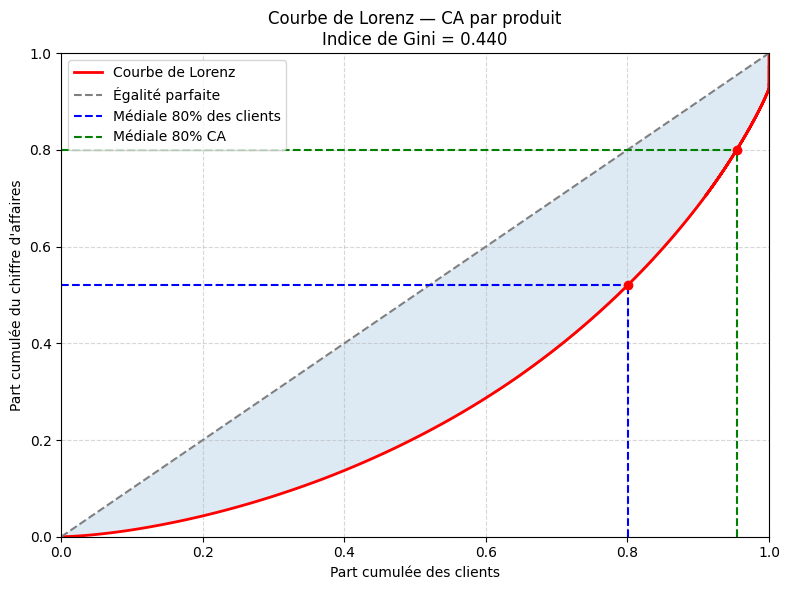

In [194]:
w = (df_tf[["client_id","price"]].dropna()
     .groupby("client_id")["price"].sum()
     .sort_values())


n = len(w)
x = np.r_[0, np.arange(1, n+1)/n]            # part cumulée des produits
y = np.r_[0, w.cumsum()/w.sum()]             # part cumulée du CA

# Gini
gini = 1 - 2*np.trapezoid(y, x)


plt.figure(figsize=(8,6))
plt.plot(x, y, color = "red", lw=2, drawstyle='steps-post', label="Courbe de Lorenz")
plt.plot([0,1], [0,1], ls='--', color='gray', label="Égalité parfaite")
plt.fill_between(x, y, x, alpha=0.15)
plt.legend(loc="upper left")

# Médial
idx = np.searchsorted(y, 0.52)
x_medial = x[idx]
y_medial = y[idx]
plt.vlines(x_medial, ymin=0, ymax=y_medial, color='blue', linestyle='--', label='Médiale 80% des clients')
plt.hlines(y_medial, xmin=0, xmax=x_medial, color='blue', linestyle='--')
plt.scatter([x_medial], [y_medial], color='red', zorder=5)

idx2 = np.searchsorted(y, 0.8)
x_medial = x[idx2]
y_medial = y[idx2]
plt.vlines(x_medial, ymin=0, ymax=y_medial, color='green', linestyle='--', label='Médiale 80% CA')
plt.hlines(y_medial, xmin=0, xmax=x_medial, color='green', linestyle='--')
plt.scatter([x_medial], [y_medial], color='red', zorder=5)

# quadrillage
ax = plt.gca()
ax.set(xlim=(0,1), ylim=(0,1),
       xlabel="Part cumulée des clients",
       ylabel="Part cumulée du chiffre d'affaires",
       title=f"Courbe de Lorenz — CA par produit\nIndice de Gini = {gini:.3f}")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.tight_layout();
plt.show()

Inégalité modérée : l’indice de Gini ≈ 0,44 traduit une concentration réelle mais non extrême du chiffre d’affaires.

80 % des clients: ~52 % du CA (trait bleu) : la majorité du portefeuille contribue de façon substantielle.

Atteindre 80 % du CA nécessite ~98–99 % des clients (trait vert) : le CA est plutôt diffus, pas de dépendance aux grossistes( ~20 % du CA).

In [195]:
df["CA"] = df_tf["price"].copy()
df=df_tf

## Répartition des âges des clients

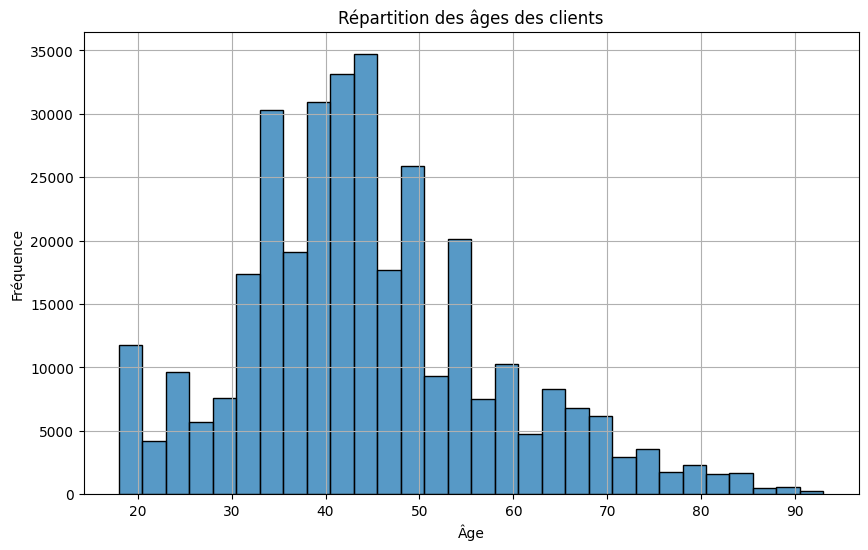

In [196]:
plt.figure(figsize=(10,6))
sns.histplot(df['age'], bins=30, kde=False)
plt.title('Répartition des âges des clients')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

## Relation entre l’âge et le chiffre d’affaires

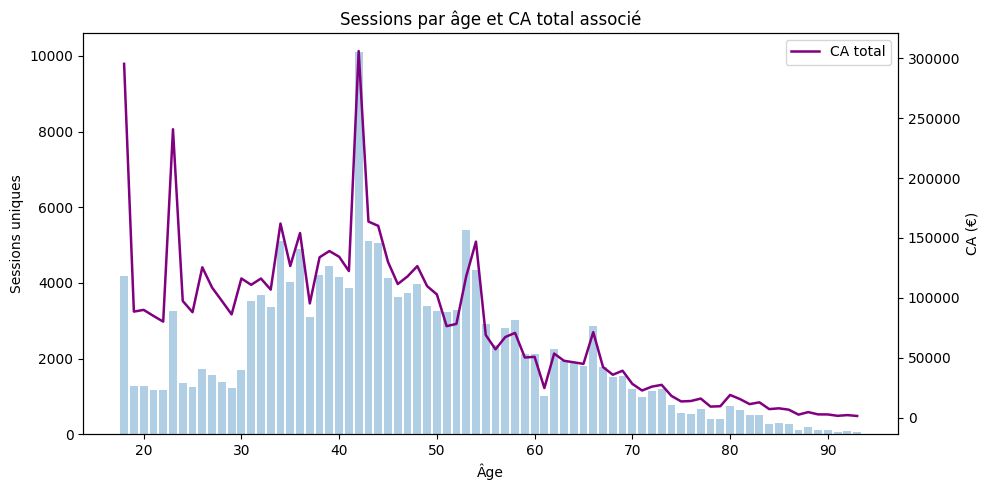

In [207]:
df = df_tf.copy()
ca_total_age = df.groupby("age")["price"].sum()
nb_sessions_age = df.groupby("age")["session_id"].nunique()

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(nb_sessions_age.index, nb_sessions_age.values, alpha=0.35)
ax1.set_ylabel("Sessions uniques"); ax1.set_xlabel("Âge")

ax2 = ax1.twinx()
ax2.plot(ca_total_age.index, ca_total_age.values, linewidth=1.8, color="purple", label="CA total")
ax2.set_ylabel("CA (€)"); ax2.legend(loc="upper right")
plt.title("Sessions par âge et CA total associé")
plt.tight_layout(); plt.show()

on analyse le CA apporté par age

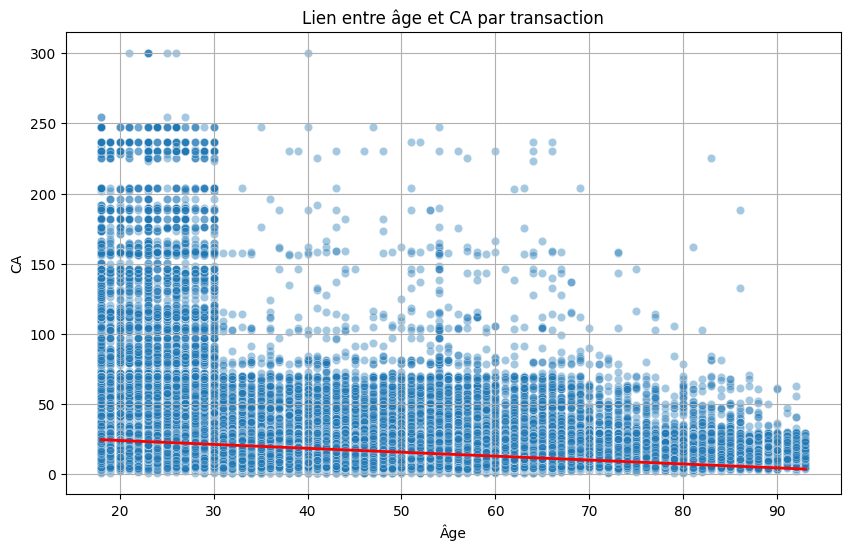

In [201]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='price', data=df, alpha=0.4)
sns.regplot(x='age',y='price',data=df,scatter=False,line_kws={"color": "red", "lw": 2})  #rég
plt.title('Lien entre âge et CA par transaction')
plt.xlabel('Âge')
plt.ylabel('CA')
plt.grid(True)
plt.show()

## Chiffre d’affaires par tranche d’âge

In [204]:
df["CA"] = df_tf["price"].copy()
df=df_tf

/tmp/ipython-input-1431734004.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


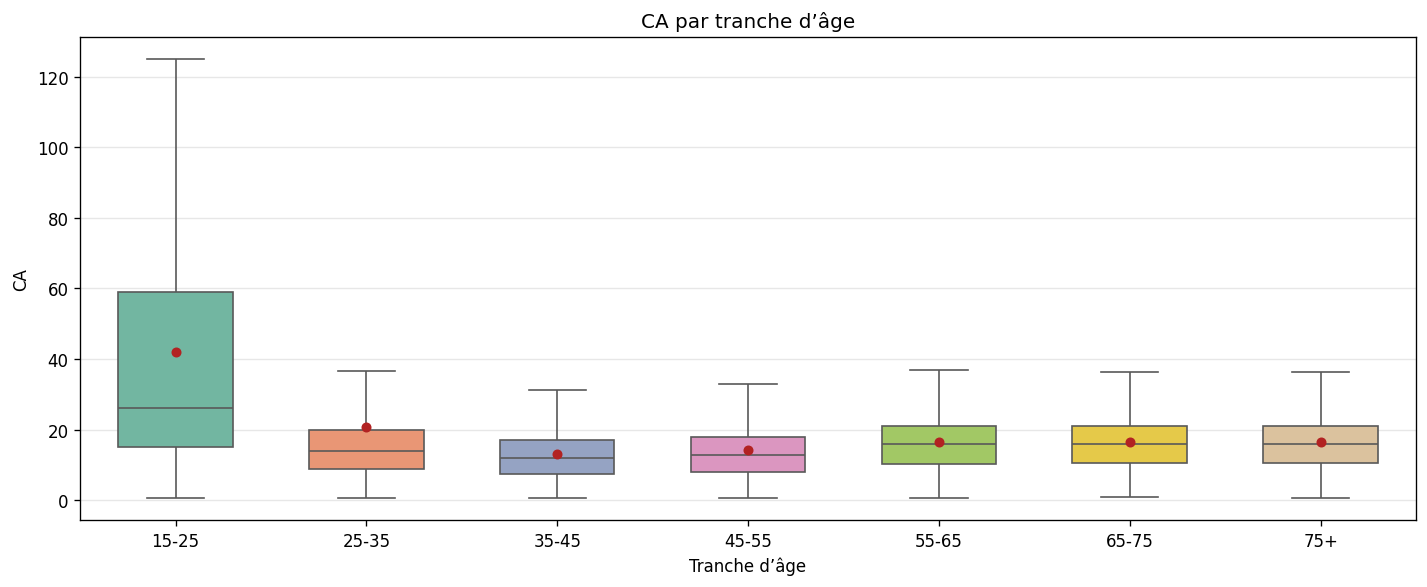

In [205]:
bins   = [15, 25, 35, 45, 55, 65, 75, 100]
labels = ['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+']

df= df[['age', 'CA']].copy()


df['tranche_age'] = pd.cut(
    df['age'], bins=bins, labels=labels,
    right=False, include_lowest=True
)

plt.figure(figsize=(12, 5), dpi=120)
sns.boxplot(
    data=df, x='tranche_age', y='CA', order=labels,
    showfliers=False, width=0.6, palette='Set2',
    showmeans=True,
    meanprops=dict(marker='o', markersize=5,
                   markerfacecolor='firebrick', markeredgecolor='firebrick')
)
plt.title('CA par tranche d’âge')
plt.xlabel('Tranche d’âge'); plt.ylabel('CA')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

15–25 ans = segment à fort potentiel de CA mais aussi instable, avec une distribution large.

25–35 ans = bon potentiel, moins dispersé mais encore dynamique.

Au-delà de 35 ans, la structure d’achat est plus uniforme et prévisible, mais moins génératrice de CA élevé.

Les outliers dans chaque tranche indiquent qu’il existe des clients premium dans tous les groupes d’âge, mais leur proportion semble plus importante chez les jeunes.

## Fréquence moyenne d'achat par age

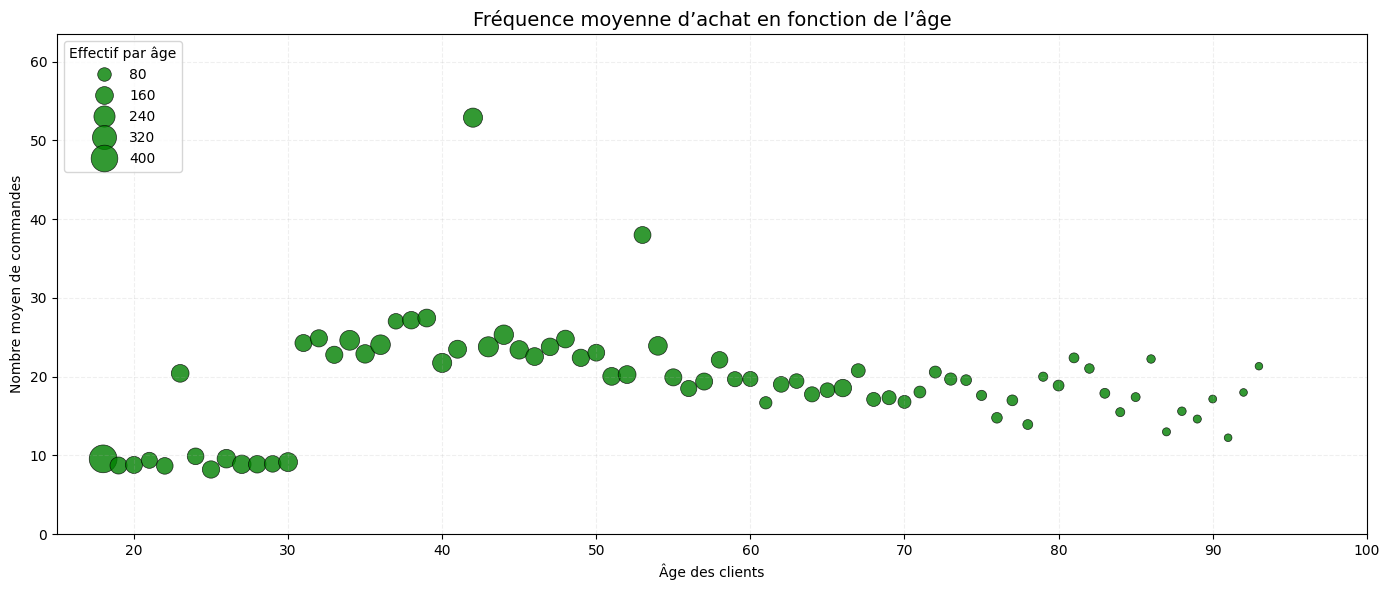

In [206]:
df = df_tf.copy()

# Nombre de commandes par client (sessions uniques)
freq_clients = (
    df.groupby("client_id", observed=True)
      .agg(nb_commandes=('session_id', 'nunique'),
           c_age=('age', 'first'))
      .dropna(subset=['c_age'])
      .reset_index(drop=True)
)

# Agrégation par âge : effectif + moyenne des commandes
freq = (
    freq_clients.groupby('c_age', observed=True)
    .agg(effectif_age=('c_age', 'count'),
         nb_commandes_moy=('nb_commandes', 'mean'))
    .reset_index()
)

plt.figure(figsize=(14, 6))

sns.scatterplot(
    data=freq,
    x='c_age', y='nb_commandes_moy',
    size='effectif_age', sizes=(30, 400),
    color='green', edgecolor='black', alpha=0.8
)

plt.xlabel("Âge des clients")
plt.ylabel("Nombre moyen de commandes")
plt.title("Fréquence moyenne d’achat en fonction de l’âge", fontsize=14)
plt.grid(linestyle='--', alpha=0.2)
plt.xlim(15, 100)
plt.xticks(np.arange(20, 101, 10))
plt.ylim(0, freq['nb_commandes_moy'].max() * 1.2)
plt.legend(title="Effectif par âge", frameon=True, loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

La fréquence d’achat augmente entre 25 et 45 ans, avec un pic autour de 40 ans, puis se stabilise à un niveau moyen (15–25 commandes) chez les plus âgés. Les jeunes sont les plus nombreux mais achètent moins souvent.

Les gros acheteurs sont rares et concentrés dans certaines tranches.

 Les 40-45 ans constituent la cible la plus active.

On compare les sessions et le CA total par âge pour dissocier fréquence et montant, et nous testons la qualité des âges pour éliminer les pics artificiels. »

/tmp/ipython-input-402985001.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


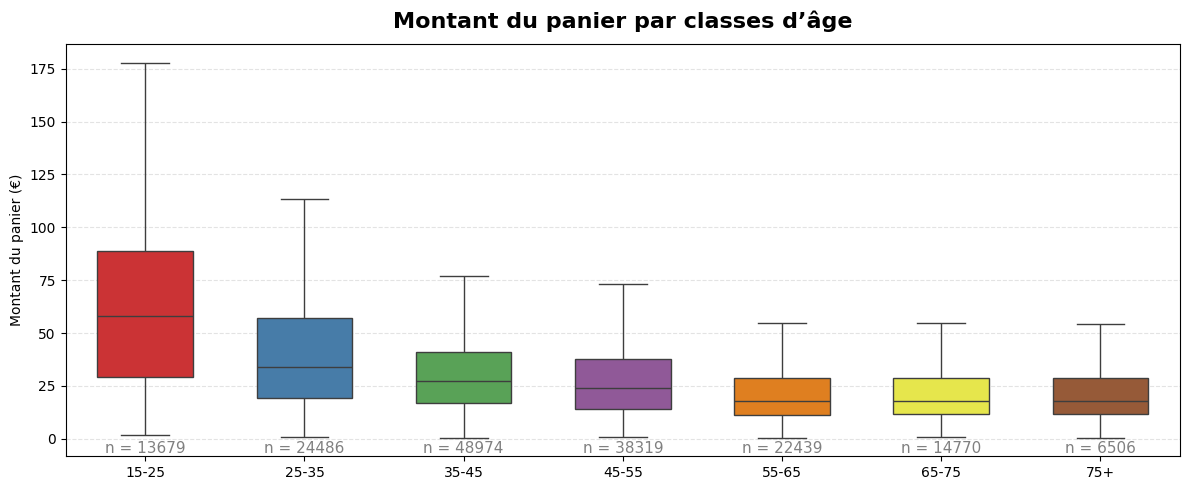

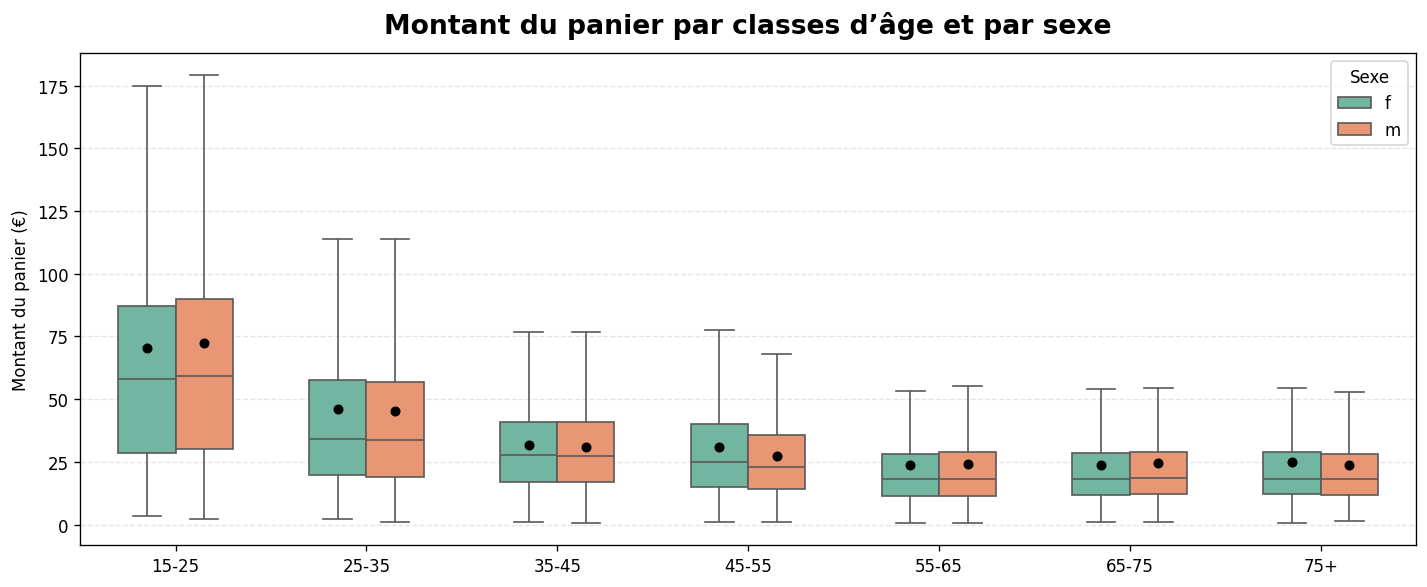

In [214]:

panier = (
    df.groupby("session_id", observed=True)
      .agg(montant_panier=("CA", "sum"),
           age=("age", "first"),
           sex=("sex", "first"))
      .dropna(subset=["age", "montant_panier"])
      .reset_index(drop=True)
)


panier["classe"] = pd.cut(panier["age"], bins=bins, right=False, labels=labels)


plt.figure(figsize=(12, 5))
sns.boxplot(
    data=panier, x="classe", y="montant_panier",
    showfliers=False, width=0.6, palette="Set1",
)

plt.title("Montant du panier par classes d’âge", pad=12, fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Montant du panier (€)")
plt.grid(axis="y", linestyle="--", alpha=0.35)


counts = panier["classe"].value_counts().reindex(labels).fillna(0).astype(int)
for i, lab in enumerate(labels):
    plt.text(i, plt.gca().get_ylim()[0], f"n = {counts.loc[lab]}",
             ha="center", va="bottom", color="gray", fontsize=11)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5), dpi=120)
sns.boxplot(
    data=panier, x="classe", y="montant_panier", hue="sex",
    showfliers=False, width=0.6, palette="Set2",
    showmeans=True, meanprops=dict(marker='o', markersize=5, markerfacecolor='black', markeredgecolor='black')
)
plt.title("Montant du panier par classes d’âge et par sexe", pad=12, fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Montant du panier (€)")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend(title="Sexe", frameon=True)
plt.tight_layout()
plt.show()

Les 15–35 ans réalisent les plus gros paniers, tandis que les plus de 45 ans ont des paniers plus faibles et plus réguliers. Le sexe n’a pas d’impact significatif, la variable âge étant dominante dans la structuration du panier moyen.

 D’un point de vue stratégique : les jeunes représentent une valeur transactionnelle forte, alors que les plus âgés offrent une base stable